## Import

In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass

## Discipline

In [2]:
from gemseo.disciplines.auto_py import AutoPyDiscipline
discipline_aerodynamic = AutoPyDiscipline(aerodynamic)
discipline_approach = AutoPyDiscipline(approach)
discipline_battery = AutoPyDiscipline(battery)
discipline_climb = AutoPyDiscipline(climb)
discipline_engine = AutoPyDiscipline(engine)
discipline_fuel_tank = AutoPyDiscipline(fuel_tank)
discipline_geometry = AutoPyDiscipline(geometry)
discipline_mass = AutoPyDiscipline(mass)
discipline_mission = AutoPyDiscipline(mission)
discipline_operating_cost = AutoPyDiscipline(operating_cost)
discipline_take_off = AutoPyDiscipline(take_off)
discipline_total_mass = AutoPyDiscipline(total_mass)


In [3]:
disciplines = [discipline_aerodynamic,discipline_approach,discipline_battery,discipline_climb,discipline_engine,
               discipline_fuel_tank,discipline_geometry,discipline_mass,discipline_mission,discipline_operating_cost,
               discipline_take_off,discipline_total_mass]

## Uncertain Space

In [4]:
from gemseo_oad_training.unit import convert_from
from gemseo.scenarios.mdo_scenario import MDOScenario
from gemseo import configure_logger

configure_logger()


<RootLogger root (INFO)>

In [5]:
from gemseo.algos.parameter_space import ParameterSpace
from utils import update_default_inputs

x_def={'slst':100004.412,'n_pax':120.0,'area':109.205,'ar':14.528,'fuel_type':'kerosene','engine_type':'turbofan','design_range':5500000}
update_default_inputs(disciplines,x_def)
uncertain_space = ParameterSpace()
uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)



In [6]:
from gemseo import sample_disciplines
from gemseo.disciplines.surrogate import SurrogateDiscipline


In [7]:
training_dataset = sample_disciplines(disciplines, uncertain_space, ["tofl", "vapp","vz","span","length","fm","mtom"], algo_name="OT_MONTE_CARLO", n_samples=10000)

    INFO - 14:51:08: *** Start Sampling execution ***
    INFO - 14:51:08: Sampling
    INFO - 14:51:08:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 14:51:08:    MDO formulation: MDF
    INFO - 14:51:08: Running the algorithm OT_MONTE_CARLO:


    INFO - 14:54:11:    100%|██████████| 10000/10000 [03:01<00:00, 55.01 it/sec]
    INFO - 14:54:11: *** End Sampling execution (time: 0:03:02.720035) ***


In [8]:
surrogate_discipline = SurrogateDiscipline("RBFRegressor", training_dataset)

In [9]:
r2 = surrogate_discipline.get_error_measure("R2Measure")
r2.compute_learning_measure(as_dict=True)


{'fm': array([1.]),
 'length': array([1.]),
 'mtom': array([1.]),
 'span': array([1.]),
 'tofl': array([1.]),
 'vapp': array([1.]),
 'vz': array([1.])}

In [10]:
r2.compute_cross_validation_measure(as_dict=True)


{'fm': array([0.99999721]),
 'length': array([nan]),
 'mtom': array([0.99999659]),
 'span': array([1.]),
 'tofl': array([0.9999965]),
 'vapp': array([0.99999667]),
 'vz': array([0.99999666])}

In [11]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_learning_measure(as_dict=True)


{'fm': array([0.00019005]),
 'length': array([0.]),
 'mtom': array([0.21448594]),
 'span': array([0.]),
 'tofl': array([0.01229615]),
 'vapp': array([5.84103399e-06]),
 'vz': array([0.00042939])}

In [12]:
rmse.compute_cross_validation_measure(as_dict=True)


{'fm': array([2.1905223e-05]),
 'length': array([0.]),
 'mtom': array([0.55840599]),
 'span': array([0.]),
 'tofl': array([0.03248432]),
 'vapp': array([0.00031846]),
 'vz': array([0.00017292])}

In [13]:
from matplotlib import pyplot as plt

from gemseo import sample_disciplines
from gemseo.algos.parameter_space import ParameterSpace
from gemseo.disciplines.analytic import AnalyticDiscipline
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics

In [14]:
statistics = EmpiricalStatistics(training_dataset)
mean = statistics.compute_mean()
mean

{'aef': array([1.00656559]),
 'cef': array([1.00654216]),
 'fm': array([0.50975042]),
 'length': array([32.]),
 'mtom': array([63468.51215818]),
 'sef': array([1.00672306]),
 'span': array([39.83127214]),
 'tofl': array([1918.86863299]),
 'vapp': array([66.64388349]),
 'vz': array([4.74026666])}

In [15]:
variance = statistics.compute_variance()
variance

{'aef': array([7.24298412e-05]),
 'cef': array([7.24760979e-05]),
 'fm': array([0.00017221]),
 'length': array([0.]),
 'mtom': array([91431.58887895]),
 'sef': array([7.2424787e-05]),
 'span': array([2.01948392e-28]),
 'tofl': array([301.69684215]),
 'vapp': array([0.03042242]),
 'vz': array([0.00894191])}

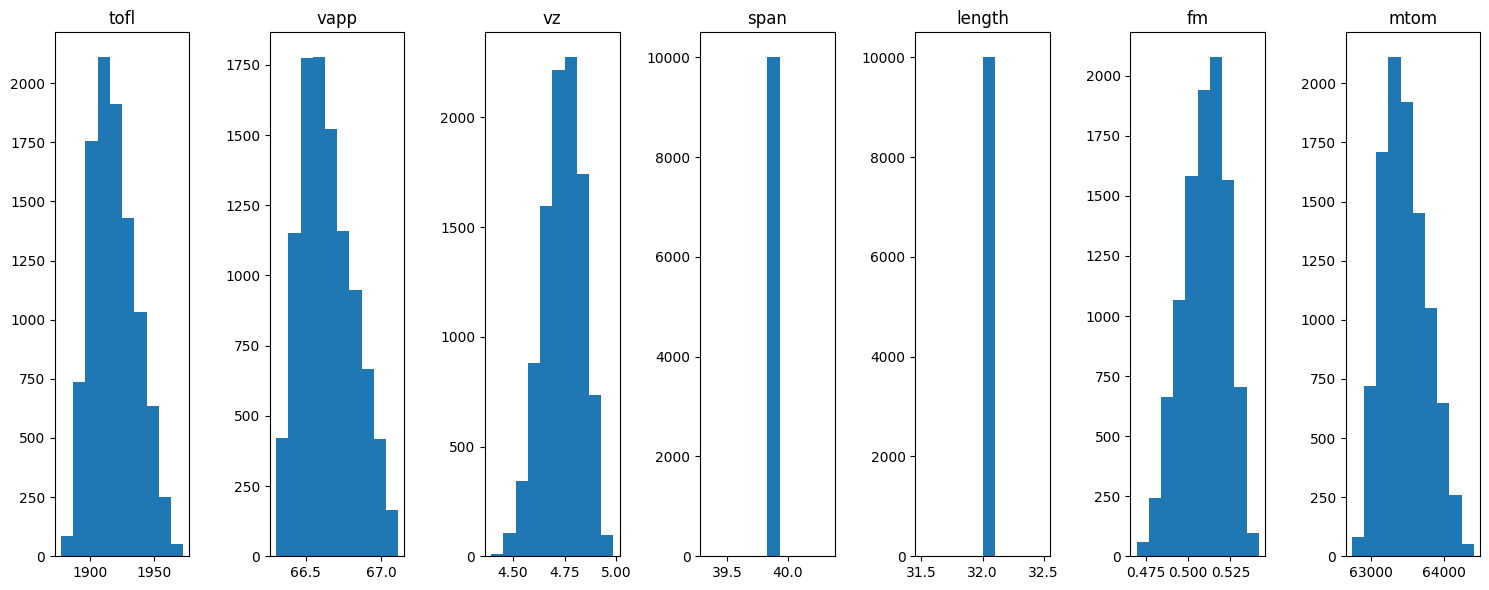

In [16]:
fig, axes = plt.subplots(1, 7,figsize=(15,6))
for ax, name in zip(axes, ["tofl", "vapp","vz","span","length","fm","mtom"]):
    ax.hist(training_dataset.get_view(variable_names=name))
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [17]:
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis


In [18]:
sobol = SobolAnalysis()
sobol.compute_samples([surrogate_discipline], uncertain_space, 5000)

 WARNING - 14:56:00: No coupling in MDA, switching chain_linearize to True.
    INFO - 14:56:00: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 14:56:00: SobolAnalysisSamplingPhase
    INFO - 14:56:00:    Disciplines: RBF_Sampling
    INFO - 14:56:00:    MDO formulation: MDF
    INFO - 14:56:00: Running the algorithm OT_SOBOL_INDICES:
    INFO - 14:57:53:    100%|██████████| 5000/5000 [01:52<00:00, 44.45 it/sec]
    INFO - 14:57:53: *** End SobolAnalysisSamplingPhase execution (time: 0:01:52.807223) ***


GROUP        inputs                       outputs                       \
VARIABLE        aef       cef       sef        fm length          mtom   
COMPONENT         0         0         0         0      0             0   
0          1.011287  1.014374  1.024023  0.495837   32.0  64155.129052   
1          0.996470  1.000938  1.011547  0.524656   32.0  63515.806914   
2          1.012159  1.004333  1.006022  0.508994   32.0  63451.381910   
3          0.999643  1.008949  1.003814  0.511283   32.0  63359.974108   
4          0.999603  1.005287  1.012760  0.516381   32.0  63619.407821   
...             ...       ...       ...       ...    ...           ...   
4995       1.019803  1.013820  1.020136  0.490820   32.0  64065.064172   
4996       1.008445  1.020580  1.014148  0.489398   32.0  63876.440334   
4997       0.997296  1.020159  1.004796  0.497613   32.0  63499.251981   
4998       1.006279  1.001426  1.007694  0.517098   32.0  63444.772564   
4999       1.006200  1.009436  1.000906  0.506065   32.0  63303.277054   

GROUP                                                   
VARIABLE        span         tofl       vapp        vz  
COMPONENT          0            0          0         0  
0          39.831272  1958.445764  66.997921  4.544280  
1          39.831272  1921.542579  66.742968  4.784437  
2          39.831272  1917.844313  66.629742  4.713503  
3          39.831272  1912.603560  66.584440  4.805764  
4          39.831272  1927.497579  66.767795  4.741193  
...              ...          ...        ...       ...  
4995       39.831272  1953.224662  66.918605  4.519369  
4996       39.831272  1942.313765  66.796207  4.628465  
4997       39.831272  1920.591898  66.604586  4.783967  
4998       39.831272  1917.465121  66.664021  4.747695  
4999       39.831272  1909.356701  66.524708  4.783596  

[5000 rows x 10 columns]

In [19]:
sobol.compute_indices(output_names=["tofl", "vapp","vz","fm","mtom"])

SobolAnalysis.SensitivityIndices(first={'tofl': [{'aef': array([0.05949934]), 'cef': array([0.11969329]), 'sef': array([1.00186254])}], 'vapp': [{'aef': array([0.00338316]), 'cef': array([0.00338255]), 'sef': array([1.14894356])}], 'vz': [{'aef': array([0.41013892]), 'cef': array([0.08829962]), 'sef': array([0.62421333])}], 'fm': [{'aef': array([0.2369472]), 'cef': array([0.75961372]), 'sef': array([0.02592165])}], 'mtom': [{'aef': array([0.05982647]), 'cef': array([0.12000539]), 'sef': array([1.00053631])}]}, second={'tofl': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.07246396]]), 'sef': array([[-0.07136355]])}, 'cef': {'aef': array([[-0.07246396]]), 'cef': array([[0.]]), 'sef': array([[-0.05231739]])}, 'sef': {'aef': array([[-0.07136355]]), 'cef': array([[-0.05231739]]), 'sef': array([[0.]])}}], 'vapp': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.00684039]]), 'sef': array([[-0.00658737]])}, 'cef': {'aef': array([[-0.00684039]]), 'cef': array([[0.]]), 'sef': array([[-0.006

In [20]:
import pprint

In [21]:
pprint.pprint(sobol.indices.first)
pprint.pprint(sobol.indices.total)

{'fm': [{'aef': array([0.2369472]),
         'cef': array([0.75961372]),
         'sef': array([0.02592165])}],
 'mtom': [{'aef': array([0.05982647]),
           'cef': array([0.12000539]),
           'sef': array([1.00053631])}],
 'tofl': [{'aef': array([0.05949934]),
           'cef': array([0.11969329]),
           'sef': array([1.00186254])}],
 'vapp': [{'aef': array([0.00338316]),
           'cef': array([0.00338255]),
           'sef': array([1.14894356])}],
 'vz': [{'aef': array([0.41013892]),
         'cef': array([0.08829962]),
         'sef': array([0.62421333])}]}
{'fm': [{'aef': array([0.17793725]),
         'cef': array([0.79792064]),
         'sef': array([-3.19564694e-05])}],
 'mtom': [{'aef': array([0.02088127]),
           'cef': array([0.08688888]),
           'sef': array([0.86775781])}],
 'tofl': [{'aef': array([0.02083667]),
           'cef': array([0.08693759]),
           'sef': array([0.86792274])}],
 'vapp': [{'aef': array([0.00014642]),
           'cef': array

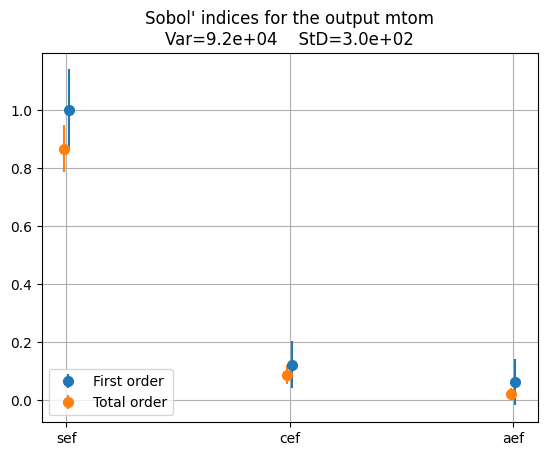

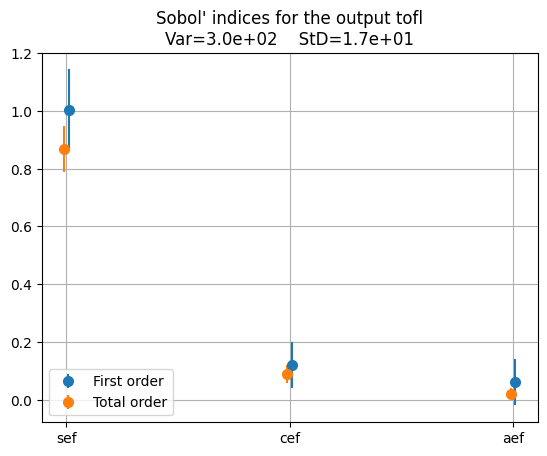

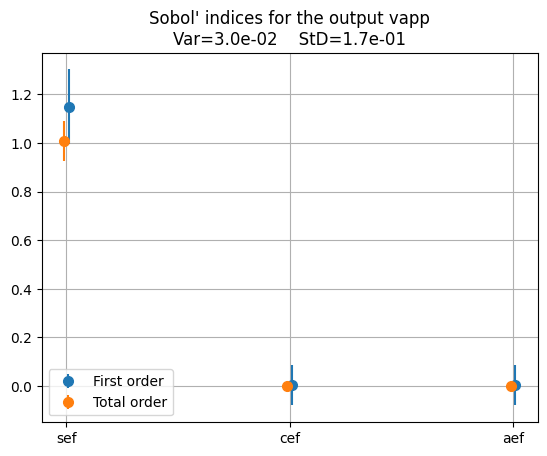

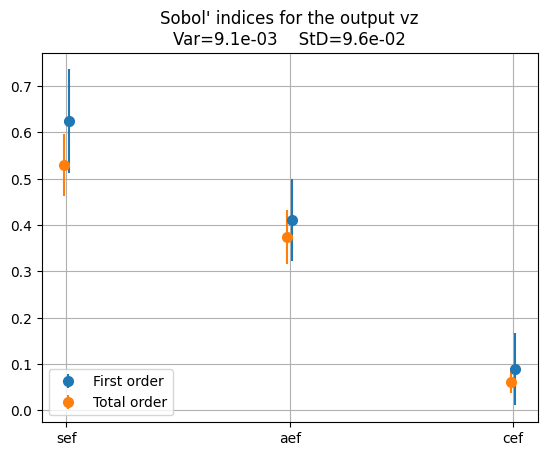

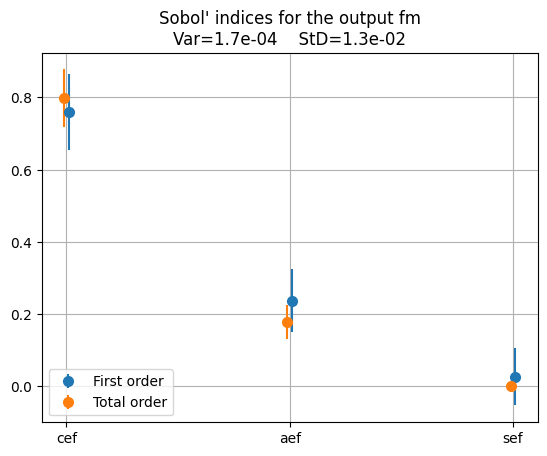

In [22]:
plt.show(sobol.plot("mtom", save=False, show=True))
plt.show(sobol.plot("tofl", save=False, show=True))
plt.show(sobol.plot("vapp", save=False, show=True))
plt.show(sobol.plot("vz", save=False, show=True))
plt.show(sobol.plot("fm", save=False, show=True))



